# Import Libraries

In [1]:
import torch
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import torch.nn.functional as F

/home/alper/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# PyTorch Implementation

In [2]:
def fgsm_attack(x, y, epsilon, model):
    x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    predictions = model(x_tensor)
    loss = F.cross_entropy(predictions, y_tensor.argmax(dim=1))

    model.zero_grad()
    loss.backward()

    gradient = x_tensor.grad.data
    perturbation = epsilon * torch.sign(gradient)

    perturbed_input = x_tensor + perturbation
    perturbed_input = torch.clamp(perturbed_input, 0, 1)

    return perturbed_input.detach().numpy(), perturbation.detach().numpy()

# TensorFlow Implementation

In [3]:
def fgsm_attack(x, y, epsilon):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        predictions = model(x_tensor)
        loss = tf.keras.losses.categorical_crossentropy(y_tensor, predictions)

    gradient = tape.gradient(loss, x_tensor)

    perturbation = epsilon * tf.sign(gradient)
    perturbed_input = x_tensor + perturbation

    perturbed_input = tf.clip_by_value(perturbed_input, 0, 1)
    return perturbed_input.numpy(), perturbation.numpy()

# Load Data

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [6]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Load Model

In [7]:
model = tf.keras.models.load_model("models/cifar10_safe_model.h5")

# Attack

In [8]:
epsilon = 0.1
idx = 0
x_sample = x_test[idx:idx+1]
y_sample = y_test[idx:idx+1]

In [9]:
perturbed_sample, perturbation = fgsm_attack(x_sample, y_sample, epsilon)

In [10]:
original_image = x_sample[0, :, :, :]
perturbation_image = perturbation[0, :, :, :]
perturbed_image = perturbed_sample[0, :, :, :]

In [11]:
original_pred = np.argmax(model.predict(x_sample), axis=1)
perturbed_pred = np.argmax(model.predict(perturbed_sample), axis=1)

print(f"Prediction before attack: {original_pred}")
print(f"Prediction after attack: {perturbed_pred}")

1/1 [==============================] - 0s 12ms/step
Prediction before attack: [3]
Prediction after attack: [5]


In [12]:
cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer",
                       "dog", "frog", "horse", "ship", "truck"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1..0.1].


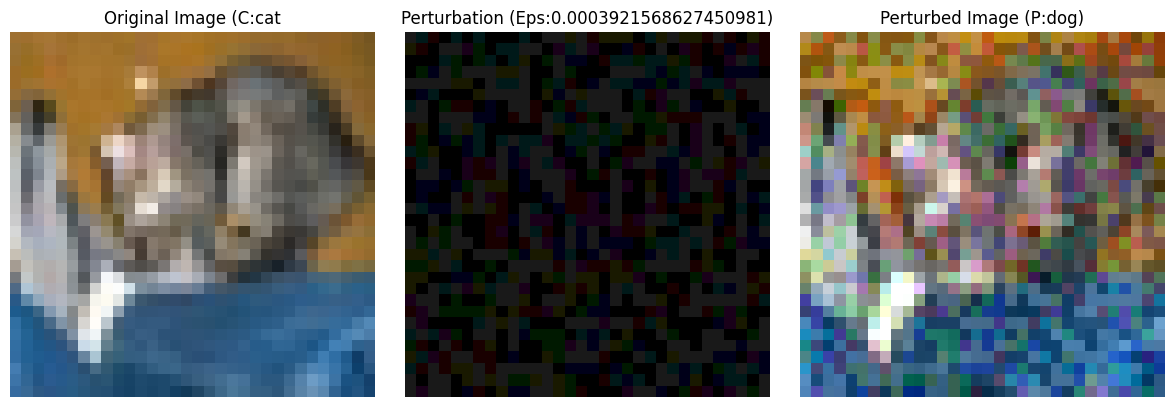

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title(f"Original Image (C:{cifar10_class_names[original_pred[0]]}")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title(f"Perturbation (Eps:{epsilon / 255})")
plt.imshow(perturbation_image)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Perturbed Image (P:{cifar10_class_names[perturbed_pred[0]]})")
plt.imshow(perturbed_image)
plt.axis("off")

plt.tight_layout()
plt.show()

In [14]:
count_dict = {"Pred True": 0, "Pred False": 0}
for epsilon in range(0, 255):
    perturbed_sample, _ = fgsm_attack(x_sample, y_sample, epsilon / 255)
    original_pred = np.argmax(model.predict(x_sample, verbose=False), axis=1)
    perturbed_pred = np.argmax(model.predict(perturbed_sample, verbose=False), axis=1)
    
    if (original_pred == perturbed_pred)[0]:
        count_dict["Pred True"] += 1
    else:
        count_dict["Pred False"] += 1

In [15]:
count_dict

{'Pred True': 1, 'Pred False': 254}